# ESDC Application

In [8]:
import sys

sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/')

# Standard libraries
import xarray as xr
import numpy as np
import pandas as pd
import h5py

# Data
from src.data.classification import load_esdc
from src.features.classification import add_drought_events, extract_df

# SVM Model and Derivative functions
from src.models.classification import svm_naive
from src.models.derivatives import SVMDerivative
from src.models.utils import predict_batches

# Visualization
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
xr.set_options(display_style='html')
plt.style.use('ggplot')

# notebook extensions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [2]:
cube_russia = load_esdc()

#### Visualize

In [3]:
from esdc.visualize import plot_xarray_on_map, plot_map

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


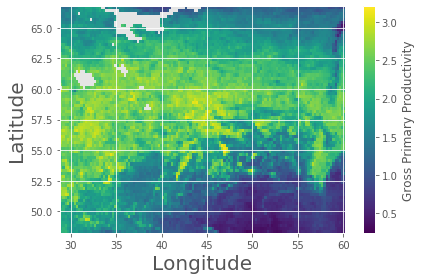

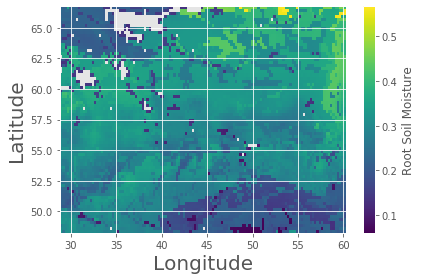

In [4]:
fig, ax = plot_map(
    cube_russia.gross_primary_productivity.sel(time=slice(str(2009), str(2009))).mean(dim='time'),
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    cube_russia.root_moisture.sel(time=slice(str(2009), str(2009))).mean(dim='time'),
    cbar_kwargs = {'label':'Root Soil Moisture'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

### Russian Drought

In [5]:
cube_russia = add_drought_events(cube_russia)
cube_russia

<xarray.Dataset>
Dimensions:                     (lat: 74, lon: 126, time: 138)
Coordinates:
  * lon                         (lon) float32 28.875 29.125 ... 59.875 60.125
  * lat                         (lat) float32 66.625 66.375 ... 48.625 48.375
  * time                        (time) datetime64[ns] 2008-01-05 ... 2010-12-31
Data variables:
    gross_primary_productivity  (time, lat, lon) float32 0.020799495 ... 0.16722402
    root_moisture               (time, lat, lon) float32 0.22968891 ... 0.22448865
    drought                     (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x720x1440
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    creator_email:             info@earthsystemdatalab.net
    creator_name:              Brockmann Consult GmbH 
    creator_url:               www.earthsystemdatalab.net
    date_created:              17.12.2018
    date_issued:               19.12.2018
    date_modified:             17.12.2018
    geospatial_lat_max:        89.75
    geospatial_lat_min:        -89.75
    geospatial_lon_max:        179.75
    geospatial_lon_min:        -179.75
    geospatial_resolution:     1/4deg
    history:                   - processing with esdl cube v0.1  (https://git...
    id:                        v2.0.0
    institution:               Brockmann Consult GmbH 
    keywords:                  Earth Science, Geophysical Variables
    license:                   Please refer to individual variables
    naming_authority:          Earth System Data Lab team
    processing_level:          Level 4
    project:                   ESA Earth System Data Lab 
    publisher_email:           info@earthsystemdatalab.net
    publisher_name:            Brockmann Consult GmbH & Max Planck Institute ...
    publisher_url:             www.brockmann-consult.de
    standard_name_vocabulary:  CF-1.7
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P37Y
    time_coverage_end:         30.12.2016
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1980
    title:                     Earth System Data Cube

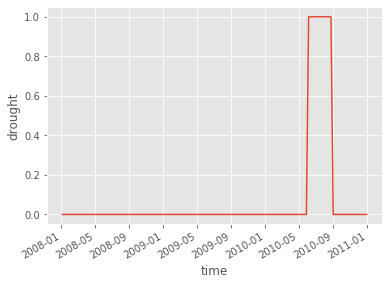

In [6]:
cube_russia.drought.mean(dim={'lon', 'lat'}).plot()

In [23]:
cube_russia_summer = dict(list(cube_russia.groupby('time.season')))['JJA']

### Input Data

In [24]:
df_russia = extract_df(cube_russia_summer)

### Train Test Split

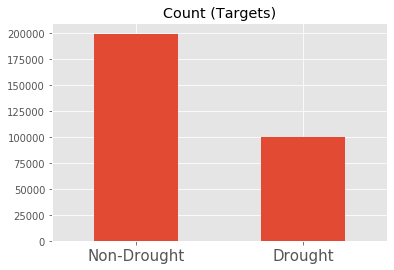

In [25]:
fig, ax = plt.subplots()
df_russia.drought.value_counts().plot(ax=ax, kind='bar', title='Count (Targets)')
ax.set_xticklabels(['Non-Drought', 'Drought'], rotation='horizontal', fontsize=15)
plt.show()

In [26]:
from sklearn.model_selection import train_test_split

#### Strategy 1: Stratify Based on class labels

In [33]:
train, test = train_test_split(df_russia, train_size=0.1, random_state=123, stratify=df_russia[['drought']])

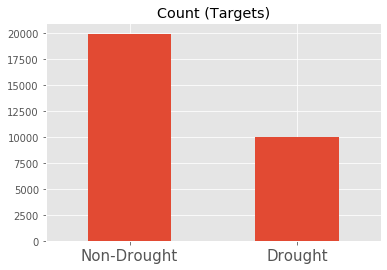

In [34]:
fig, ax = plt.subplots()
train.drought.value_counts().plot(ax=ax, kind='bar', title='Count (Targets)')
ax.set_xticklabels(['Non-Drought', 'Drought'], rotation='horizontal', fontsize=15)
plt.show()

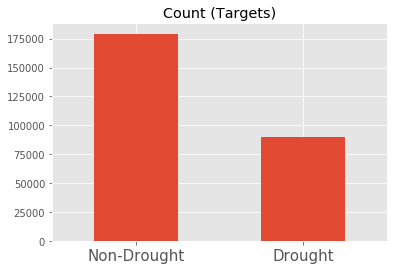

In [35]:
fig, ax = plt.subplots()
test.drought.value_counts().plot(ax=ax, kind='bar', title='Count (Targets)')
ax.set_xticklabels(['Non-Drought', 'Drought'], rotation='horizontal', fontsize=15)
plt.show()

In [36]:
meta_vars = ['lat', 'lon', 'time']
input_vars = ['gross_primary_productivity', 'root_moisture']
output_vars = ['drought']

## Algorithm

### Support Vector Machine

In [37]:
svm_naive?

Signature: svm_naive(X_train, y_train, n_grid: int = 20, **kwargs) -> sklearn.base.BaseEstimator
Docstring:
Naive implementation of the Support Vector Machine
classifcation function in the scikit-learn package. It
returns all of the necessary things needed to analyze the
results and possibly reuse the trained SVC model.

Parameters
----------
X_train : array, (N x D)
      an array of training points

y_train : array, (N x 1)
      an array of labels for the training points

n_grid : int, default=100
      the number of grid points to use for the parameter grid

kwargs : dict
      a dictionary of keyword arguments to use for the gridsearch. 
      Please see the sklearn.svm.SVC function for more details
      on the available arguments

Returns
-------

model : class,
      a class of the SVMModel.

Information
-----------
Author: J. Emmanuel Johnson
Email : jej2744@rit.edu
      : emanjohnson91@gmail.com
Date  : 11th April, 2017
File:      ~/projects/2019_sakame/src/models/classifica

In [38]:
train[output_vars].head()

,drought
215425,0.0
88884,0.0
230685,0.0
206951,0.0
119272,0.0


In [ ]:
# fit SVM model
svm_model = svm_naive(
    X_train=train[input_vars],
    y_train=train[output_vars],
    n_grid=30,
    verbose=1,
    n_jobs=-1,
)

svm_model

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 101.0min


In [ ]:
import joblib

MODEL_PATH = "/home/emmanuel/projects/2019_sakame/models/interim/"
save_name = "esdc_svm"
joblib.dump(svm_model, MODEL_PATH + save_name + '.jb')

### Predictions

In [ ]:
from src.models.classification import predict_batches

In [ ]:
# initialize SVM Derivative Model
svm_der_model = SVMDerivative(svm_model)

(
    predictions, 
    derivatives, 
    decision_derivatives, 
    objective_derivatives, 
    mask_derivatives,
    kernel_derivatives
) = predict_batches(
    svm_model, 
    svm_der_model, 
    Xtest.values, 
    ytest.values, 
    batch_size=10_000
)

### Derivative 

### Demo: Predicting Drought